In [4]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import Author, compare_nets

%matplotlib inline

## Load data

In [5]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

In [24]:
nAuth = 500
nAuthSt = 200 # how many authors we start with
nMeetings = 200
learn_thr = .1
c = 3
diam = 3
net_size_o = 500
bib_length = 70
woman_perc_i = .3
meet_method = 'soc'
woman_perc_f = sum([x['gender'] == 'woman' for x in node_2_gender.values()])/len(node_2_gender)
colors = ['#d97d5b', '#4a3b90', '#5295d0', '#fabc50']

In [7]:
# original parameters

net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.40,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (.15,.02)
forget_m = (.15,.02)

### Walk Bias - random walks

In [8]:
net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.50,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (.15,.02)
forget_m = (.15,.02)

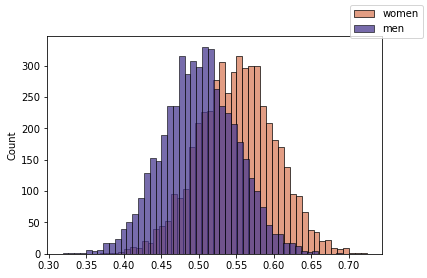

In [9]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

In [10]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.normal(loc=forget_m[0],scale=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.normal(loc=forget_w[0],scale=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    
# group meeting function
def group_meet(n, authors, idx, w_perc):
    curr_meets = {}
    for j in range(int(n)):        
        # pick author for meeting
        k = np.random.choice(idx)
        
        # check if at least one will meet
        [m12,m21] = compare_nets(authors[j], authors[k], meet_method)
        if any([m12,m21]):
            # if yes, update the network
            if m12:
                bib = authors[k].get_cites(bib_length)
                authors[j].update_network(bib, authors[k].network, learn_thr)
            if m21:
                bib = authors[j].get_cites(bib_length)
                authors[k].update_network(bib, authors[j].network, learn_thr)
        # forget
        authors[j].forget()
        authors[k].forget()
        # log information
        # update meets
        curr_meets[j] = {'gender1': authors[j].gender, 'gender2':authors[k].gender, 'meet12':m12, 'meet21':m21}
    
    # get network size
    net_size = (np.mean([len(a.memory) for a in authors]),np.std([len(a.memory) for a in authors]))
    # update cites
    bibs = [a.get_cites(bib_length) for a in authors]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if not(w_index[i])]
    cite_perc = np.mean([cite['gender'] == 'woman' for b in bibs for cite in b.values()])
    cite_perc_w = np.mean([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()])
    cite_perc_m = np.mean([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()])
    
    return curr_meets, cite_perc, cite_perc_w, cite_perc_m, net_size

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nMeetings))
new_w_perc = ((woman_perc_f*nAuth) - (woman_perc_i*nAuthSt))/(nAuth-nAuthSt) # with probability should the added authors be women?
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nMeetings):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        for j in range(int(dn)):
            f = np.random.rand(1,1)
            a = []
            if f >= new_w_perc:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

100%|██████████| 200/200 [20:49<00:00,  6.25s/it]


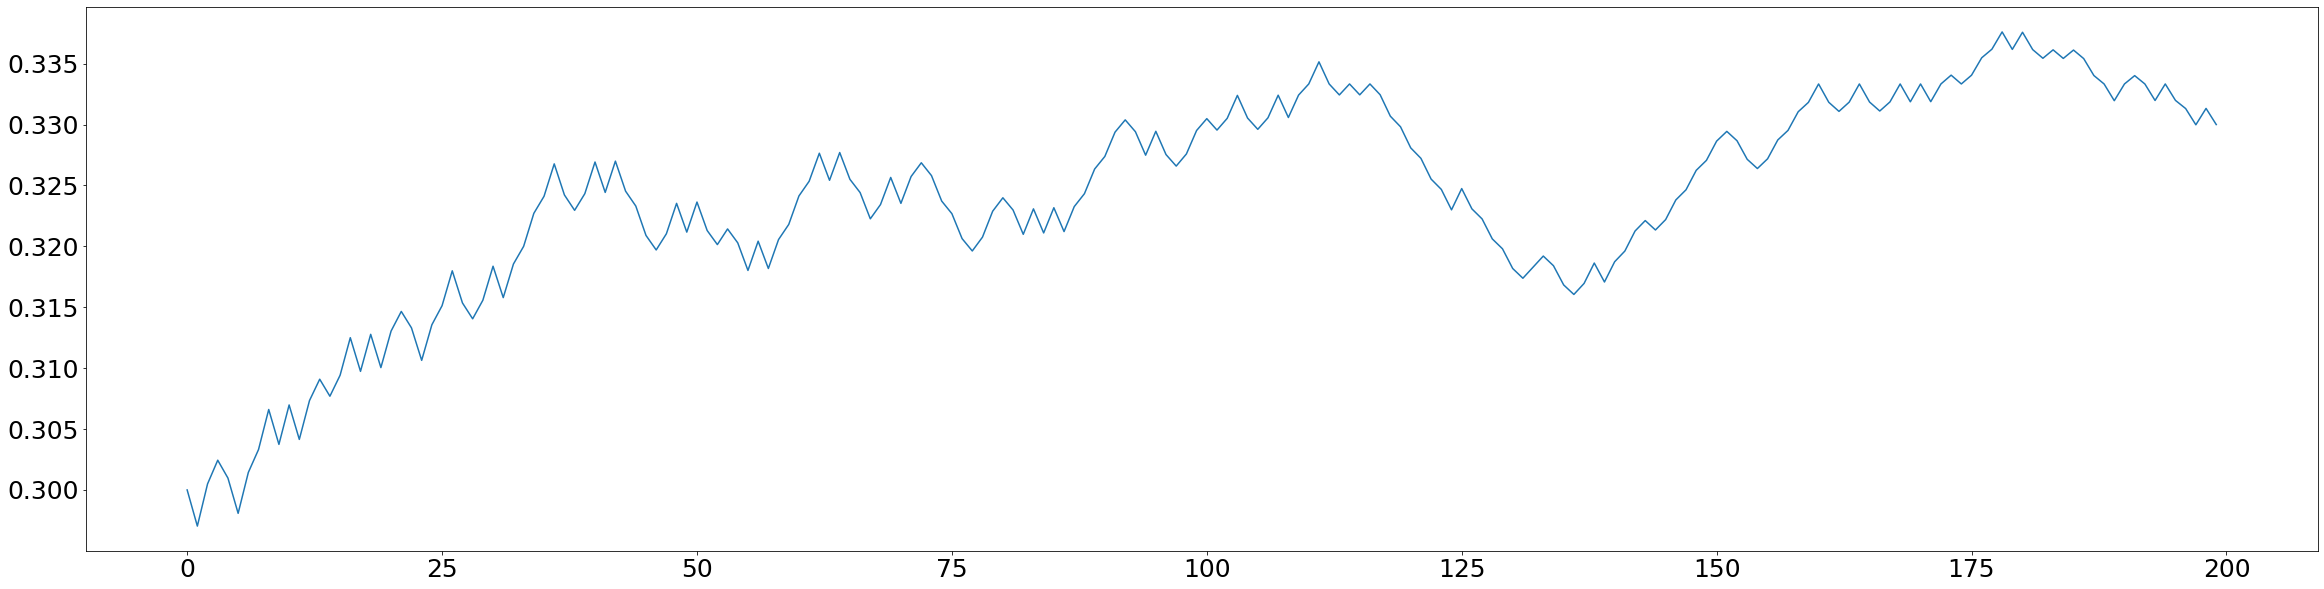

In [11]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = Parallel(n_jobs=1)(
    delayed(group_meet)(sim_params[i]['n'], authors, sim_params[i]['author_idx'], sim_params[i]['woman_perc'])
    for i,b in enumerate(tqdm(range(nMeetings))) 
)

# intialize final data structs
meets = {}; # keep track of when meetings were successful
citation_perc = []
citation_perc_w = []
citation_perc_m = []
net_size = []

# reformat data
for i,d in enumerate(data):    
    curr_meets, cite_perc, cite_perc_w, cite_perc_m, ns = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    citation_perc.append((np.mean(cite_perc),np.std(cite_perc)))
    citation_perc_w.append((np.mean(cite_perc_w),np.std(cite_perc_w)))
    citation_perc_m.append((np.mean(cite_perc_m),np.std(cite_perc_m)))
    net_size.append(ns)

#### Plots

<AxesSubplot:>

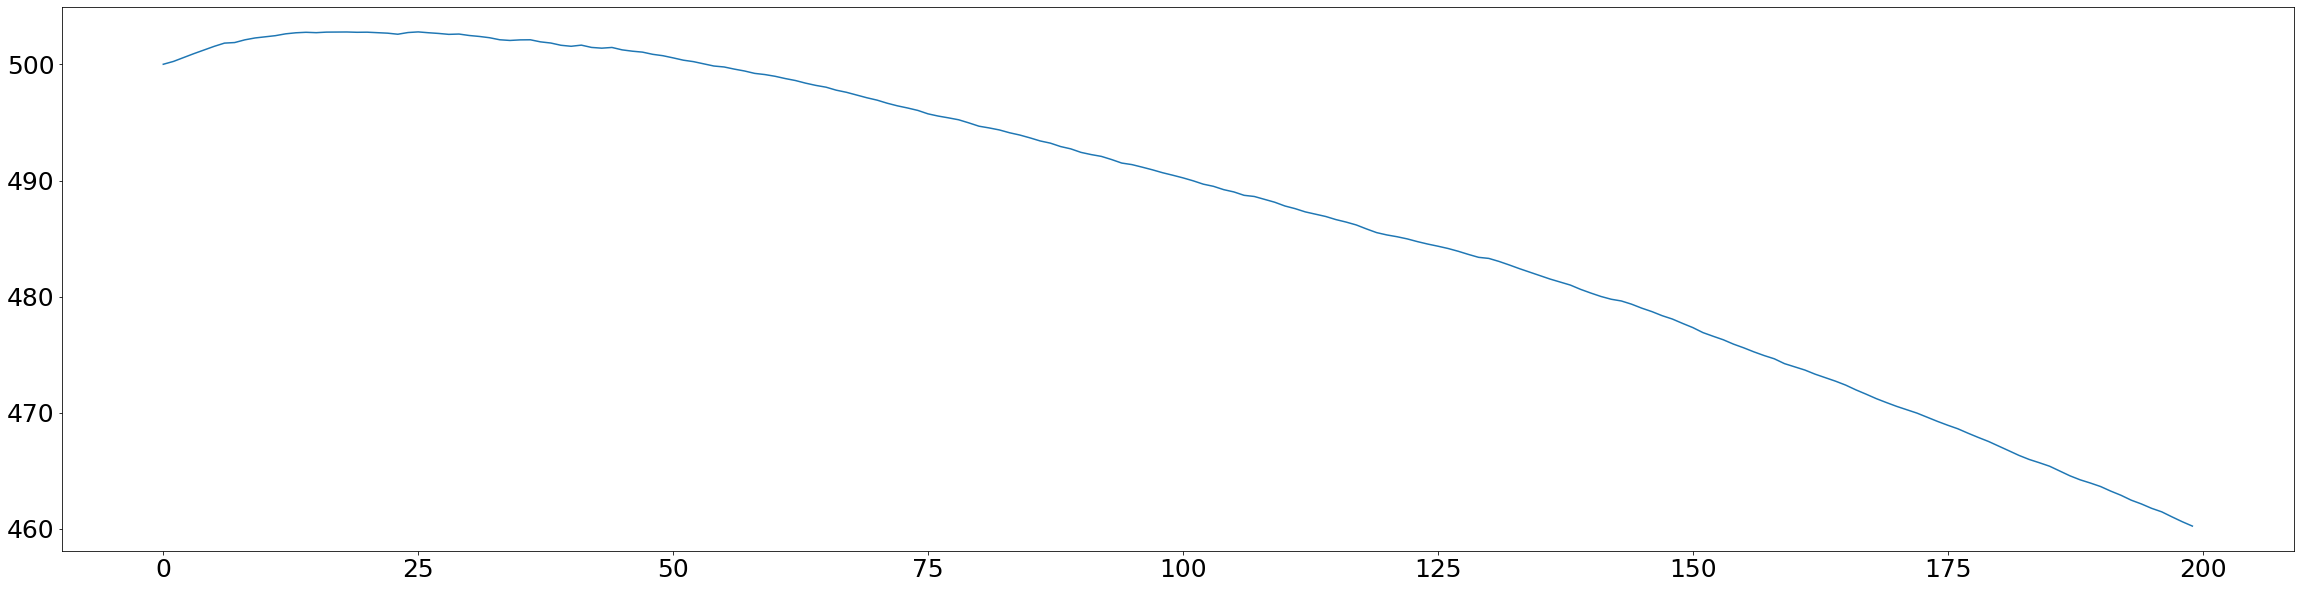

In [12]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

Text(0.5, 1.0, 'Different Gender Meetings')

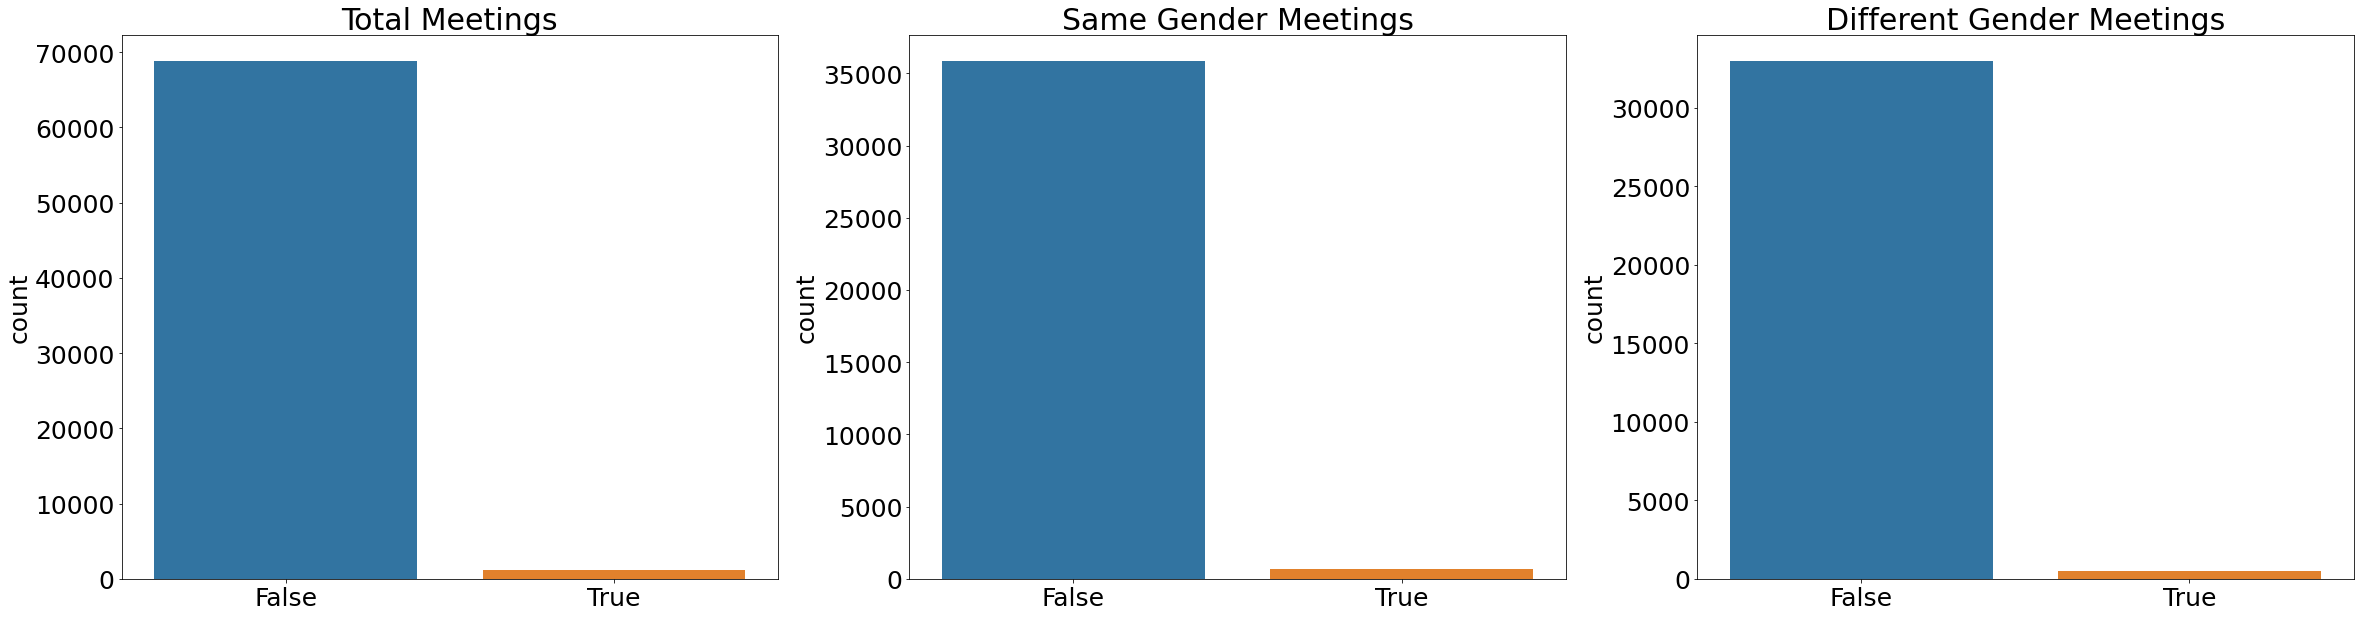

In [13]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

Text(0.5, 1.0, 'Percentage citation of women')

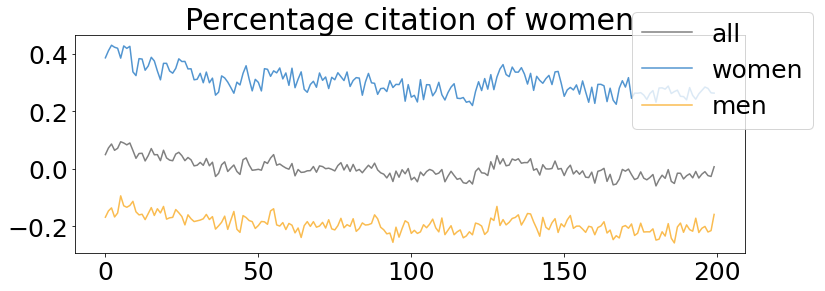

In [14]:
f,ax = plt.subplots(1,1,figsize=(12,4))
percs = [x['woman_perc'] for x in sim_params.values()]
sns.lineplot(data=(np.array([x[0] for x in citation_perc])/percs) - 1, color='grey',ax=ax)
sns.lineplot(data=(np.array([x[0] for x in citation_perc_w])/percs) - 1, color=colors[2],ax=ax)
sns.lineplot(data=(np.array([x[0] for x in citation_perc_m])/percs) - 1, color=colors[3],ax=ax)
f.legend(labels=['all','women','men'])
ax.set_title('Percentage citation of women')

Text(0.5, 1.0, 'Womens Citation Practices')

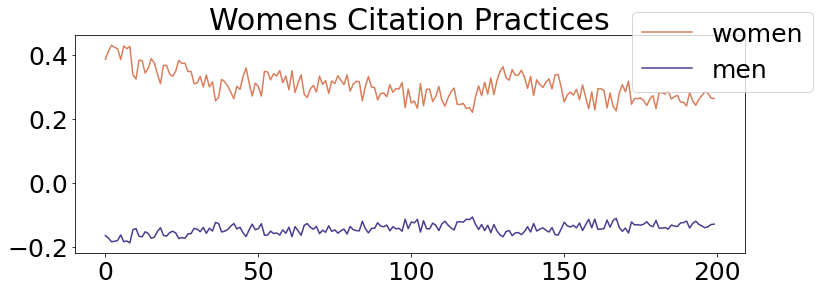

In [15]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array([x[0] for x in citation_perc_w]) - percs)/percs), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array([x[0] for x in citation_perc_w])) - ([1 - x for x in percs]))/([1 - x for x in percs]), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Womens Citation Practices')

Text(0.5, 1.0, 'Mens Citation Practices')

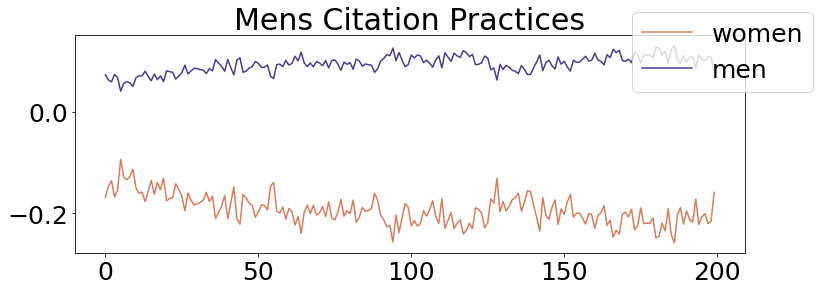

In [16]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array([x[0] for x in citation_perc_m]) - percs)/percs), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array([x[0] for x in citation_perc_m])) - ([1 - x for x in percs]))/([1 - x for x in percs]), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Mens Citation Practices')

### Walk Bias - bias towards women

In [20]:
net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.80,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (.15,.02)
forget_m = (.15,.02)


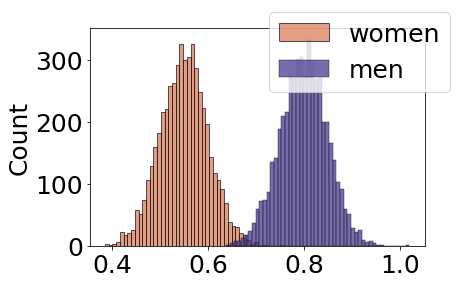

In [21]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

In [25]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.normal(loc=forget_m[0],scale=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.normal(loc=forget_w[0],scale=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    
# group meeting function
def group_meet(n, authors, idx, w_perc):
    curr_meets = {}
    for j in range(int(n)):        
        # pick author for meeting
        k = np.random.choice(idx)
        
        # check if at least one will meet
        [m12,m21] = compare_nets(authors[j], authors[k], meet_method)
        if any([m12,m21]):
            # if yes, update the network
            if m12:
                bib = authors[k].get_cites(bib_length)
                authors[j].update_network(bib, authors[k].network, learn_thr)
            if m21:
                bib = authors[j].get_cites(bib_length)
                authors[k].update_network(bib, authors[j].network, learn_thr)
        # forget
        authors[j].forget()
        authors[k].forget()
        # log information
        # update meets
        curr_meets[j] = {'gender1': authors[j].gender, 'gender2':authors[k].gender, 'meet12':m12, 'meet21':m21}
    
    # get network size
    net_size = (np.mean([len(a.memory) for a in authors]),np.std([len(a.memory) for a in authors]))
    # update cites
    bibs = [a.get_cites(bib_length) for a in authors]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if not(w_index[i])]
    cite_perc = np.mean([cite['gender'] == 'woman' for b in bibs for cite in b.values()])
    cite_perc_w = np.mean([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()])
    cite_perc_m = np.mean([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()])
    
    return curr_meets, cite_perc, cite_perc_w, cite_perc_m, net_size

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nMeetings))
new_w_perc = ((woman_perc_f*nAuth) - (woman_perc_i*nAuthSt))/(nAuth-nAuthSt) # with probability should the added authors be women?
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nMeetings):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        for j in range(int(dn)):
            f = np.random.rand(1,1)
            a = []
            if f >= new_w_perc:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

100%|██████████| 200/200 [25:23<00:00,  7.62s/it]


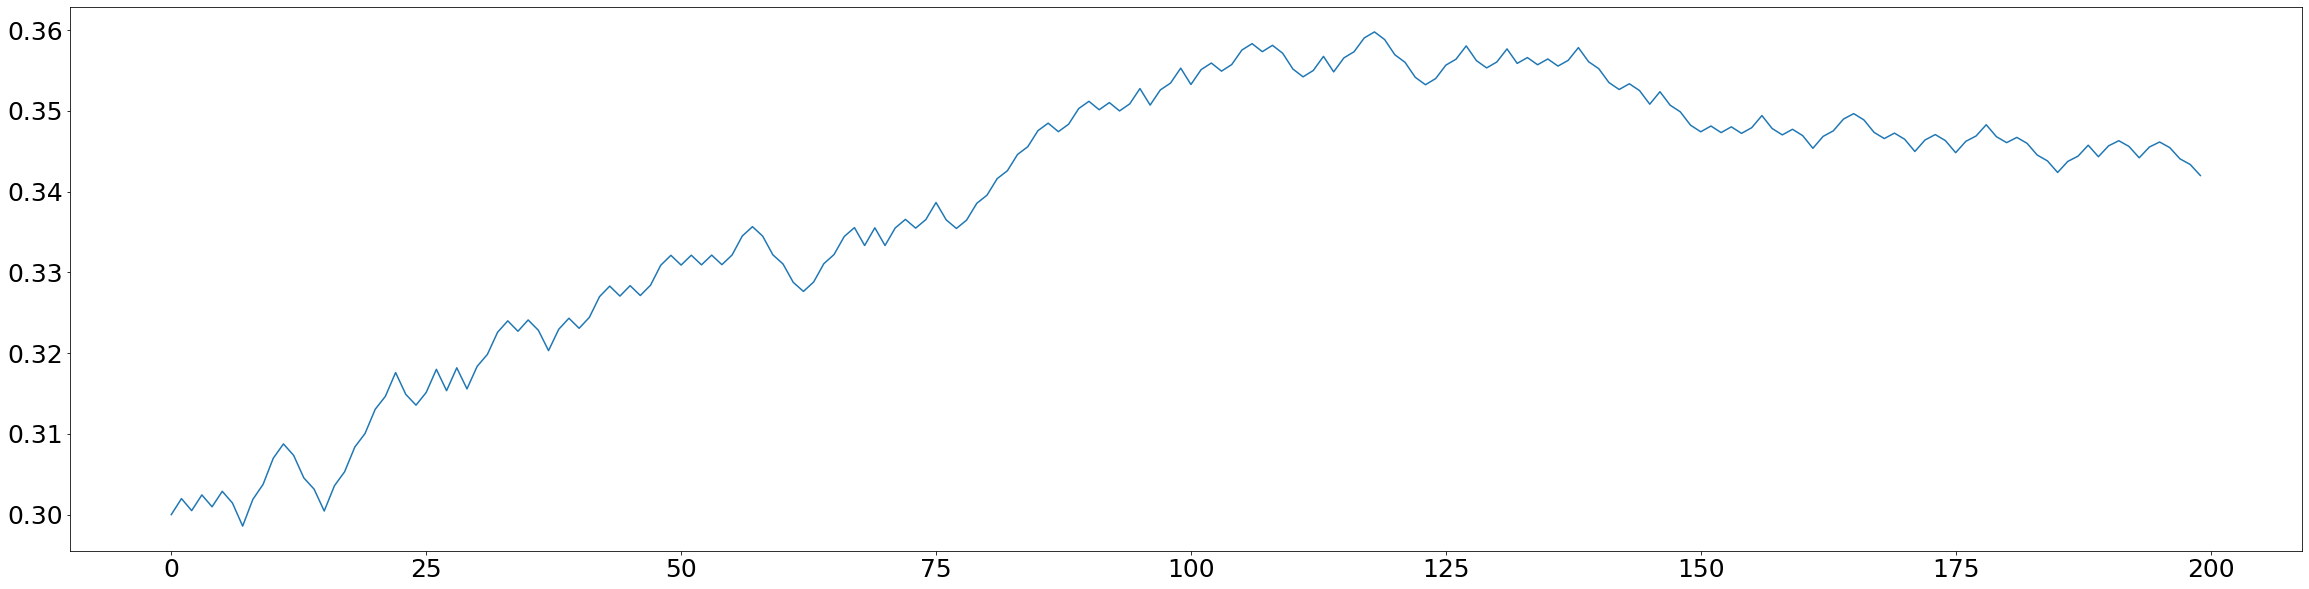

In [26]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = Parallel(n_jobs=1)(
    delayed(group_meet)(sim_params[i]['n'], authors, sim_params[i]['author_idx'], sim_params[i]['woman_perc'])
    for i,b in enumerate(tqdm(range(nMeetings))) 
)

# intialize final data structs
meets = {}; # keep track of when meetings were successful
citation_perc = []
citation_perc_w = []
citation_perc_m = []
net_size = []

# reformat data
for i,d in enumerate(data):    
    curr_meets, cite_perc, cite_perc_w, cite_perc_m, ns = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    citation_perc.append((np.mean(cite_perc),np.std(cite_perc)))
    citation_perc_w.append((np.mean(cite_perc_w),np.std(cite_perc_w)))
    citation_perc_m.append((np.mean(cite_perc_m),np.std(cite_perc_m)))
    net_size.append(ns)

#### Plots

<AxesSubplot:>

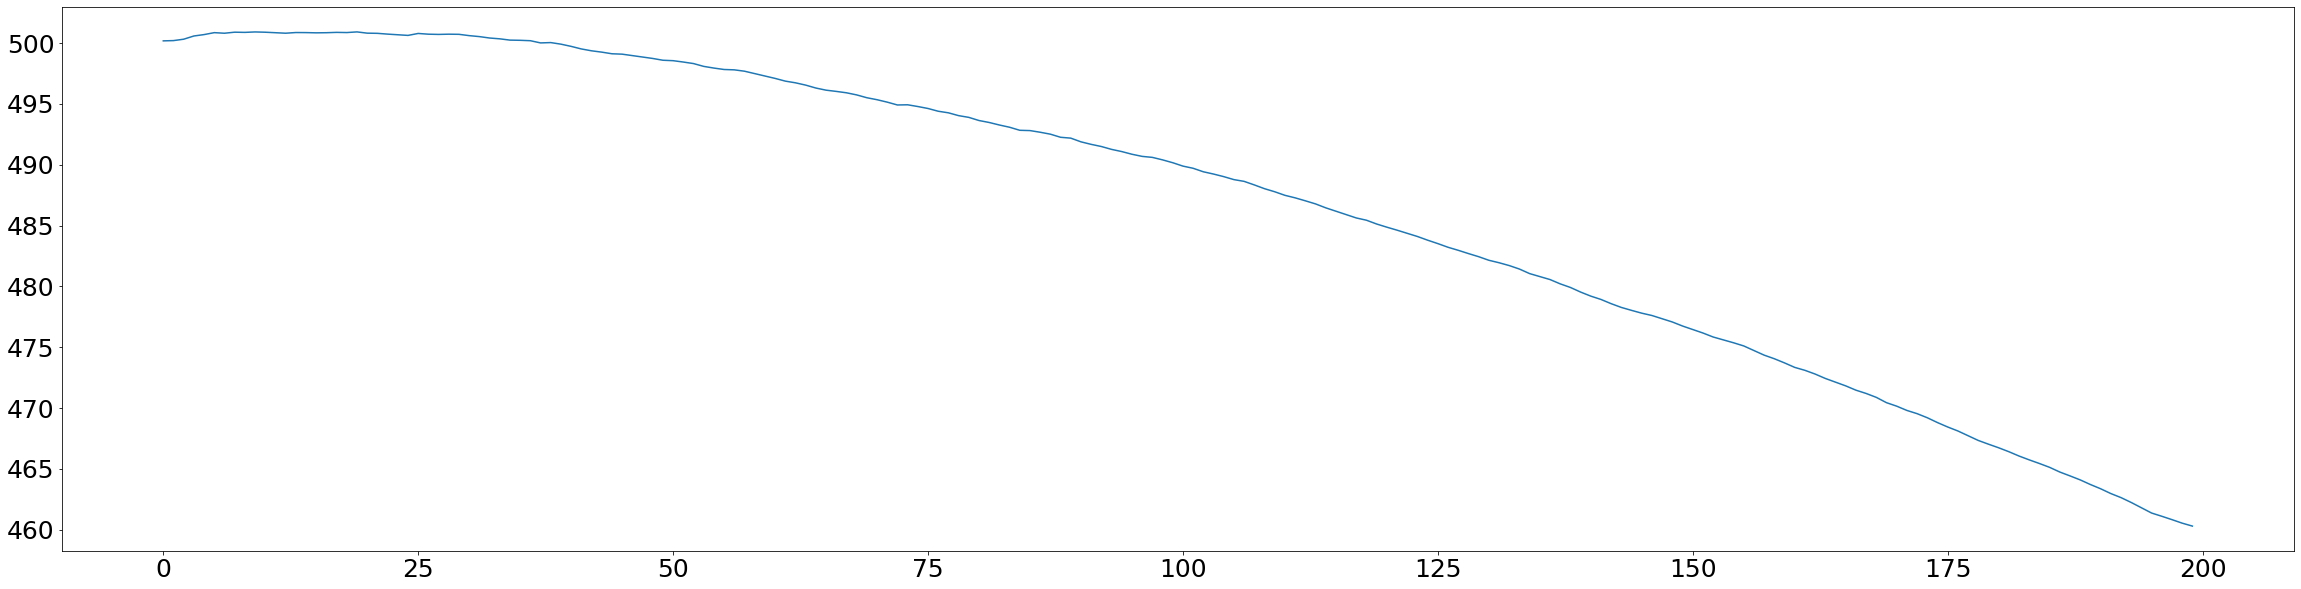

In [27]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

Text(0.5, 1.0, 'Different Gender Meetings')

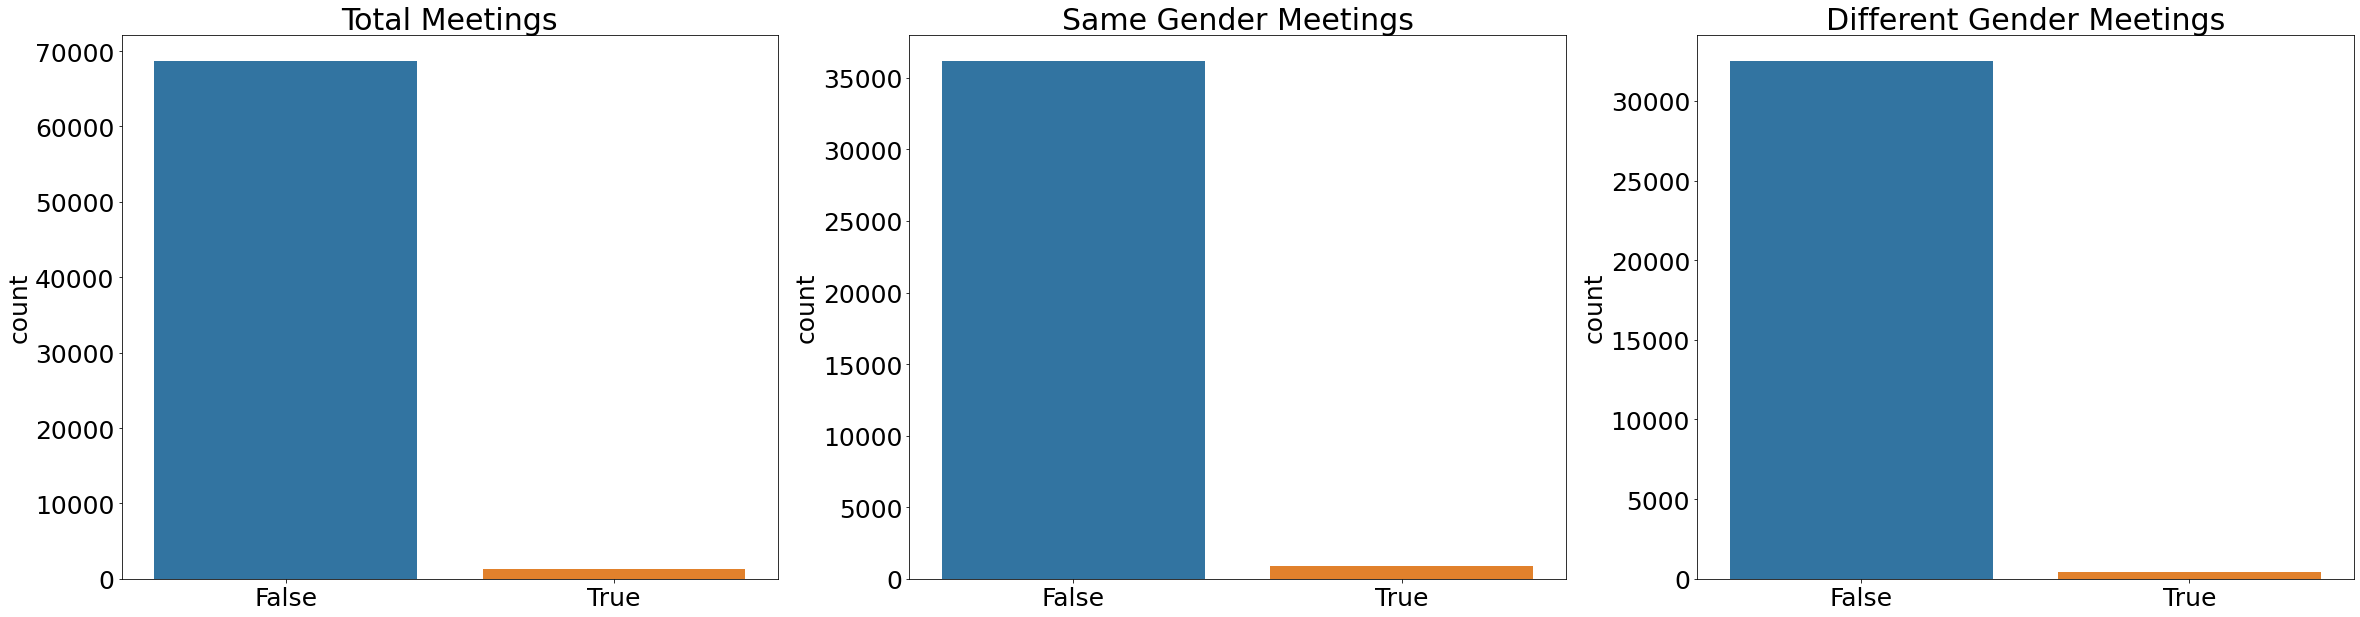

In [28]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

Text(0.5, 1.0, 'Percentage citation of women')

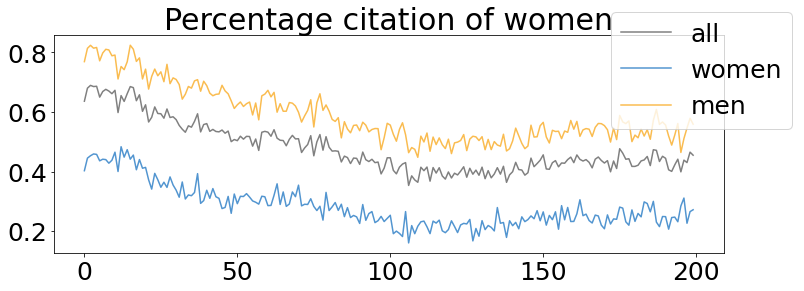

In [29]:
f,ax = plt.subplots(1,1,figsize=(12,4))
percs = [x['woman_perc'] for x in sim_params.values()]
sns.lineplot(data=(np.array([x[0] for x in citation_perc])/percs) - 1, color='grey',ax=ax)
sns.lineplot(data=(np.array([x[0] for x in citation_perc_w])/percs) - 1, color=colors[2],ax=ax)
sns.lineplot(data=(np.array([x[0] for x in citation_perc_m])/percs) - 1, color=colors[3],ax=ax)
f.legend(labels=['all','women','men'])
ax.set_title('Percentage citation of women')

Text(0.5, 1.0, 'Womens Citation Practices')

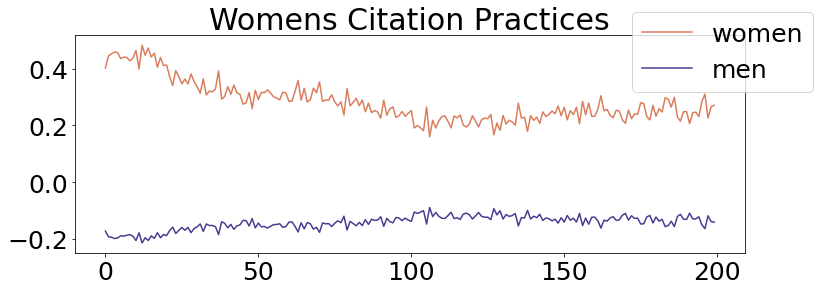

In [30]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array([x[0] for x in citation_perc_w]) - percs)/percs), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array([x[0] for x in citation_perc_w])) - ([1 - x for x in percs]))/([1 - x for x in percs]), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Womens Citation Practices')

Text(0.5, 1.0, 'Mens Citation Practices')

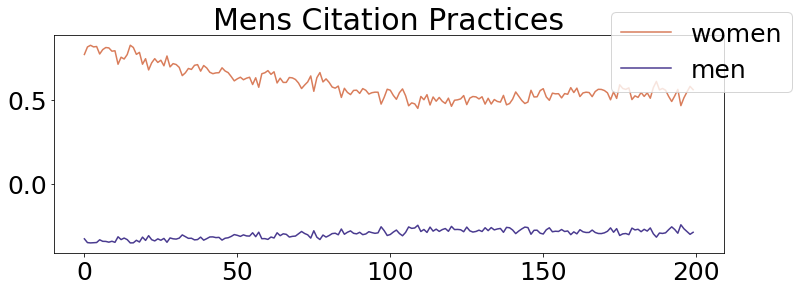

In [31]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array([x[0] for x in citation_perc_m]) - percs)/percs), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array([x[0] for x in citation_perc_m])) - ([1 - x for x in percs]))/([1 - x for x in percs]), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Mens Citation Practices')

### Meet bias - more openness

In [39]:
net_w = (.55,.1)
net_m = (.4,.1)
walk_w = (.55,.05)
walk_m = (.40,.05)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.001,0.00005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)
forget_w = (.15,.02)
forget_m = (.15,.02)

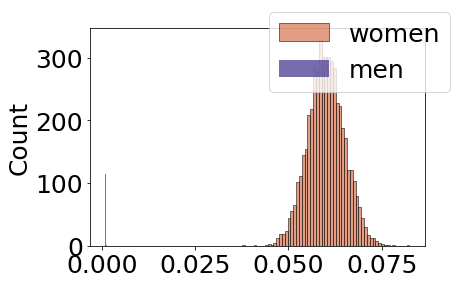

In [40]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[0])
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[1])
f.legend(labels=['women','men'])

<AxesSubplot:>

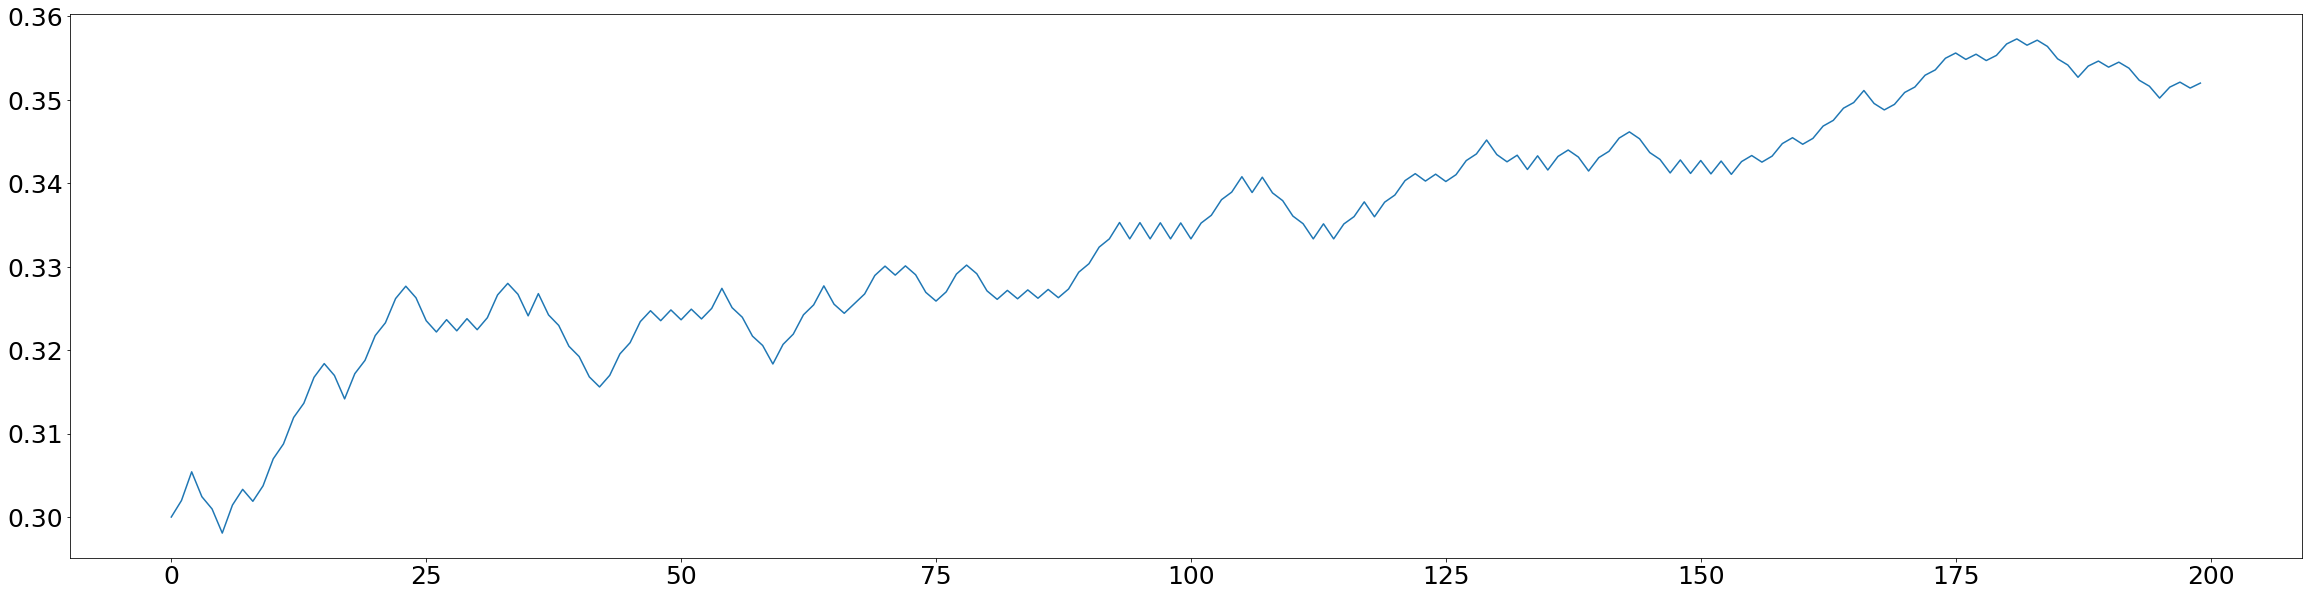

In [41]:
# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
        forget = np.random.normal(loc=forget_m[0],scale=forget_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
        forget = np.random.normal(loc=forget_w[0],scale=forget_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,forget,gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    
# group meeting function
def group_meet(n, authors, idx, w_perc):
    curr_meets = {}
    for j in range(int(n)):        
        # pick author for meeting
        k = np.random.choice(idx)
        
        # check if at least one will meet
        [m12,m21] = compare_nets(authors[j], authors[k], meet_method)
        if any([m12,m21]):
            # if yes, update the network
            if m12:
                bib = authors[k].get_cites(bib_length)
                authors[j].update_network(bib, authors[k].network, learn_thr)
            if m21:
                bib = authors[j].get_cites(bib_length)
                authors[k].update_network(bib, authors[j].network, learn_thr)
        # forget
        authors[j].forget()
        authors[k].forget()
        # log information
        # update meets
        curr_meets[j] = {'gender1': authors[j].gender, 'gender2':authors[k].gender, 'meet12':m12, 'meet21':m21}
    
    # get network size
    net_size = (np.mean([len(a.memory) for a in authors]),np.std([len(a.memory) for a in authors]))
    # update cites
    bibs = [a.get_cites(bib_length) for a in authors]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if not(w_index[i])]
    cite_perc = np.mean([cite['gender'] == 'woman' for b in bibs for cite in b.values()])
    cite_perc_w = np.mean([cite['gender'] == 'woman' for b in bibs_w for cite in b.values()])
    cite_perc_m = np.mean([cite['gender'] == 'woman' for b in bibs_m for cite in b.values()])
    
    return curr_meets, cite_perc, cite_perc_w, cite_perc_m, net_size

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nMeetings))
new_w_perc = ((woman_perc_f*nAuth) - (woman_perc_i*nAuthSt))/(nAuth-nAuthSt) # with probability should the added authors be women?
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nMeetings):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        for j in range(int(dn)):
            f = np.random.rand(1,1)
            a = []
            if f >= new_w_perc:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

In [ ]:
# run simulation
data = Parallel(n_jobs=1)(
    delayed(group_meet)(sim_params[i]['n'], authors, sim_params[i]['author_idx'], sim_params[i]['woman_perc'])
    for i,b in enumerate(tqdm(range(nMeetings))) 
)

# intialize final data structs
meets = {}; # keep track of when meetings were successful
citation_perc = []
citation_perc_w = []
citation_perc_m = []
net_size = []

# reformat data
for i,d in enumerate(data):    
    curr_meets, cite_perc, cite_perc_w, cite_perc_m, ns = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    citation_perc.append((np.mean(cite_perc),np.std(cite_perc)))
    citation_perc_w.append((np.mean(cite_perc_w),np.std(cite_perc_w)))
    citation_perc_m.append((np.mean(cite_perc_m),np.std(cite_perc_m)))
    net_size.append(ns)

 46%|████▋     | 93/200 [56:54<2:24:53, 81.25s/it]

In [ ]:
#### Plots

In [ ]:
# network size
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

In [ ]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
percs = [x['woman_perc'] for x in sim_params.values()]
sns.lineplot(data=(np.array([x[0] for x in citation_perc])/percs) - 1, color='grey',ax=ax)
sns.lineplot(data=(np.array([x[0] for x in citation_perc_w])/percs) - 1, color=colors[2],ax=ax)
sns.lineplot(data=(np.array([x[0] for x in citation_perc_m])/percs) - 1, color=colors[3],ax=ax)
f.legend(labels=['all','women','men'])
ax.set_title('Percentage citation of women')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array([x[0] for x in citation_perc_w]) - percs)/percs), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array([x[0] for x in citation_perc_w])) - ([1 - x for x in percs]))/([1 - x for x in percs]), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Womens Citation Practices')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=((np.array([x[0] for x in citation_perc_m]) - percs)/percs), color=colors[0],ax=ax)
sns.lineplot(data=((1 - np.array([x[0] for x in citation_perc_m])) - ([1 - x for x in percs]))/([1 - x for x in percs]), color=colors[1],ax=ax)
f.legend(labels=['women','men'])
ax.set_title('Mens Citation Practices')